In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
import mlflow
import mlflow.sklearn
import optuna
from random import randint
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Base Models (+ ST assessor)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC#, SVR # kernels: 'linear', 'poly' e 'rbf'
from sklearn.neural_network import MLPClassifier
from kan import KANClassifier
from sklearn.ensemble import RandomForestClassifier#, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

with open('config.json', 'r') as f:
    CONFIG = json.load(f)

In [3]:
from train_models import *

In [4]:
def load_all_models(experiments:str|list, model_names:list=CONFIG['BASE_MODELS']) -> dict:
    models = {}

    if(isinstance(experiments, str)):
        experiments = [experiments]*len(model_names)
    else:
        if(len(experiments) != len(model_names)):
            raise ValueError('Variável "experiments" deve ser uma lista com tamanho igual à "models", ou ser apenas uma string')

    for i in range(len(model_names)):
        trained_model, _ = load_model_by_name(experiments[i], model_names[i])
        models[model_names[i]] = trained_model

    return models

In [5]:
class Pool():
    def __init__(self, models):
        self.predictors = models
        #self.keys = list(models.keys())
        #self.predict_cache = None
        #self.predict_proba_cache = None
        self._is_fitted = False
        self.tree_based = ['Decision_Tree','Random_Forest','Gradient_Boosting','AdaBoost','XGBoost']
    
    def __len__(self):
        return len(self.predictors)

    def fit(self, X, X_norm, y):
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                model.fit(X,y)
            else:
                model.fit(X_norm,y)
            print(f'{name} fitted.')
        self._is_fitted = True

        return self

    def predict(self, X, X_norm):
        pred = pd.DataFrame(columns=list(self.predictors.keys()))
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                pred[name] = model.predict(X)
            else:
                pred[name] = model.predict(X_norm)
        return pred

    def predict_proba(self, X, X_norm):
        pred = {}
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                pred[name] = model.predict_proba(X)
            else:
                pred[name] = model.predict_proba(X_norm)
        return pred
    
    def drop(self, *args):
        new_models = {}
        for name, model in self.predictors.items():
            if(name not in args):
                new_models[name] = model
        newPool = Pool(new_models)
        newPool._is_fitted = self._is_fitted
        return newPool

#class PoolRejector():
#    def __init__(self):
#        pass

In [21]:
from math import floor
from scipy import stats as st

class Rejector():
    def __init__(self, model_pool:Pool):
        self.setModelPool(model_pool)
        self.cache_input = None
        self.cache_output_preds = None
        self.cache_output_proba = None

    def setModelPool(self, model_pool):
        if(model_pool._is_fitted):
            self.predictors = model_pool
        else:
            print('Warning: Pool of models not yet fitted. Model pool not saved.')

    def predictWithReject(self, X, X_norm, reject_rate, reject_method:str='avg'):
        # reject_method deve ser igual a 'avg', 'median', 'min' ou 'max'
        if(reject_method not in ['avg', 'mean', 'median', 'min','max']):
            raise ValueError("reject_method deve ser igual a 'avg', 'mean, 'median', 'min' ou 'max'")
        
        if(self.predictors._is_fitted):
            if(isinstance(X, pd.DataFrame)):
                X = X.to_numpy()
            if((X == self.cache_input).all() and (self.cache_output_proba.shape[1]==len(self.predictors))):
                predictions = self.cache_output_preds
                poolProb = self.cache_output_proba
            else:
                poolProb = pd.DataFrame()
                poolPreds = pd.DataFrame()
                results = self.predictors.predict_proba(X, X_norm)

                for name, probas in results.items():
                    poolPreds[name] = np.argmax(probas, axis=1)
                    poolProb[name] = 1 - np.max(probas, axis=1)

                predictions = pd.DataFrame(np.array(st.mode(poolPreds.values, axis=1))[0])

                self.cache_input = X
                self.cache_output_preds = predictions
                self.cache_output_proba = poolProb

            if(reject_method=='max'):
                predictions['score'] = poolProb.apply(lambda x: max(x), axis=1)
            elif(reject_method=='median'):
                predictions['score'] = poolProb.apply(lambda x: np.median(x), axis=1)
            elif(reject_method=='min'):
                predictions['score'] = poolProb.apply(lambda x: min(x), axis=1)
            else: #avg or mean
                predictions['score'] = poolProb.apply(lambda x: np.mean(x), axis=1)

            if(reject_rate > 1):
                reject_rate = reject_rate/100

            n_reject = floor(poolProb.shape[0] * reject_rate)
            if(n_reject==0):
                print('Warning: Number of rejections equals 0. Increase the rejection rate.')
            elif(n_reject==poolProb.shape[0]):
                print('Warning: All examples will be rejected. Decrease the rejection rate.')

            predictions = predictions.sort_values(by='score', ascending=False)
            predictions.iloc[:n_reject, :] = np.nan # REJECTED
            predictions = predictions.drop(columns=['score']).sort_index()

            return predictions[0]

- **Versões:**
  - v0: Versão inicial. Sem assessores. Apenas cálculo de confiança para rejeição por meio da probabilidade de classe dos modelos.

# TWO MOONS

In [ ]:
#from train_models import experiment_name

experiment_name = getExpName('airbnb')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/494908295467387025', creation_time=1759707535932, experiment_id='494908295467387025', last_update_time=1759707535932, lifecycle_stage='active', name='v0_1246495320', tags={}>

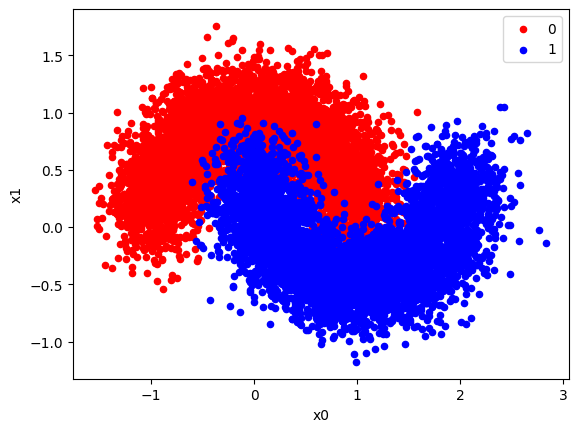

In [14]:
# generate 2d classification dataset
X, y = make_moons(n_samples=CONFIG['TWO_MOONS']['N_SAMPLES'], 
                  noise=CONFIG['TWO_MOONS']['NOISE'], 
                  random_state=CONFIG['SEED'])
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=CONFIG['SEED'])

scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [6]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

937a626718cd4a9f80529c1aa5a49a11


3977094c807a417b90e947f9bb3ef35f


81fbbd13b2304d2f87a9ce4813ff0e9f


330bc02845f148788f1447fc74f84843


081ad4a8935649918e70027ba965da1d


5b66802190ec435196842f88905f9ee7


4957b9df8f40411d8bfca7a2e72e056c


77203a99e6484c18a331f89c8dde817b


4e2c1460d7134cc090f47db3917c9b38


4581e75635e5404ca6cc79d0b1c8b10c


8634629504dd41bf9cdf22cfb76d9df7


f3150119303b475181e4f9964d95e692


In [108]:
modelPool = Pool(models)
modelPool = modelPool.fit(X_train, X_train_norm, y_train)

Decision_Tree fitted.
SGD fitted.
Logistic_Regression fitted.
KNN fitted.


/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1023).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM_Linear fitted.


/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2627).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM_Polynomial fitted.


/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1108).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM_RBF fitted.
MLP fitted.
Random_Forest fitted.
Gradient_Boosting fitted.
AdaBoost fitted.
XGBoost fitted.


In [22]:
modelPool.predict(X_test, X_test_norm)

,Decision_Tree,SGD,Logistic_Regression,KNN,SVM_Linear,SVM_Polynomial,SVM_RBF,MLP,Random_Forest,Gradient_Boosting,AdaBoost,XGBoost
0,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,0,0,1,1,1,1,1,1,1,1,1
2996,1,0,0,1,1,1,1,1,1,1,1,1
2997,0,0,0,0,0,0,0,0,0,0,0,0
2998,1,1,1,1,1,1,1,1,1,1,1,1


In [26]:
teste = modelPool.predict_proba(X_test, X_test_norm)
teste

{'Decision_Tree': array([[0.        , 1.        ],
        [0.07142857, 0.92857143],
        [0.        , 1.        ],
        ...,
        [1.        , 0.        ],
        [0.        , 1.        ],
        [1.        , 0.        ]], shape=(3000, 2)),
 'SGD': array([[0.35777328, 0.64222672],
        [0.14683902, 0.85316098],
        [0.11679206, 0.88320794],
        ...,
        [0.93240344, 0.06759656],
        [0.        , 1.        ],
        [1.        , 0.        ]], shape=(3000, 2)),
 'Logistic_Regression': array([[0.26025194, 0.73974806],
        [0.0918628 , 0.9081372 ],
        [0.07822786, 0.92177214],
        ...,
        [0.88492997, 0.11507003],
        [0.02778958, 0.97221042],
        [0.93933575, 0.06066425]], shape=(3000, 2)),
 'KNN': array([[0.04761905, 0.95238095],
        [0.0952381 , 0.9047619 ],
        [0.04761905, 0.95238095],
        ...,
        [1.        , 0.        ],
        [0.        , 1.        ],
        [1.        , 0.        ]], shape=(3000, 2)),
 '

In [118]:
pred_reject = Rejector(modelPool)
y_pred = pred_reject.predictWithReject(X_test, X_test_norm, 0.2, 'avg')
y_pred

0       1.0
1       1.0
2       1.0
3       NaN
4       NaN
       ... 
2995    1.0
2996    1.0
2997    0.0
2998    NaN
2999    0.0
Name: 0, Length: 3000, dtype: float64

In [124]:
predictions = pred_reject.cache_output_preds
poolProb = pred_reject.cache_output_proba

predictions['score'] = poolProb.apply(lambda x: np.mean(x), axis=1)

n_reject = floor(poolProb.shape[0] * 0.2)
if(n_reject==0):
    print('Warning: Number of rejections equals 0. Increase the rejection rate.')
elif(n_reject==poolProb.shape[0]):
    print('Warning: All examples will be rejected. Decrease the rejection rate.')

predictions = predictions.sort_values(by='score', ascending=False)
#predictions.iloc[:n_reject, :] = np.nan # REJECTED
#predictions = predictions.drop(columns=['score']).sort_index()
predictions

,0,score
1528,1,0.424002
827,0,0.421382
322,0,0.420449
73,0,0.419025
598,1,0.415453
...,...,...
363,1,0.033875
1406,1,0.033746
2440,1,0.033199
2093,1,0.033095


In [134]:
pred_reject = Rejector(modelPool)
results_log = pd.DataFrame(columns=['Method','Rejection Rate','Accuracy','Precision','Recall','F1-Score'])

for method in ['avg','median','min','max']:
    #score = {'avg':[],'median':[],'min':[],'max':[]}
    for reject_rate in range(5,96,5):
        y_pred = pred_reject.predictWithReject(X_test, X_test_norm, reject_rate, method)
        idx = y_pred.dropna().index
        acc = accuracy_score(y_test[idx], y_pred[idx])
        pre = precision_score(y_test[idx], y_pred[idx], zero_division=0)
        rec = recall_score(y_test[idx], y_pred[idx], zero_division=0)
        f1s = f1_score(y_test[idx], y_pred[idx], zero_division=0)
        results_log.loc[results_log.shape[0]] = [method,reject_rate*0.01,acc,pre,rec,f1s]

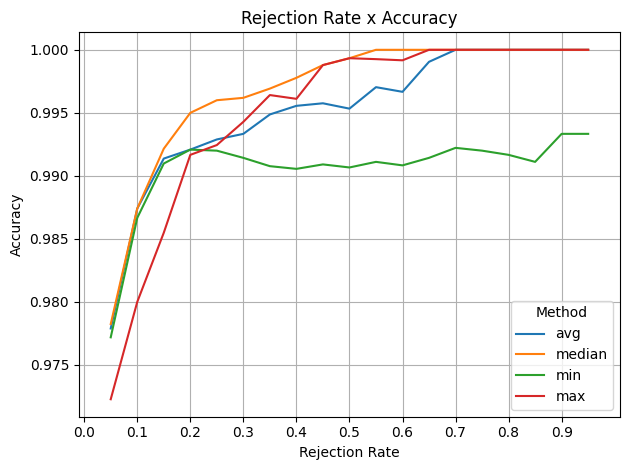

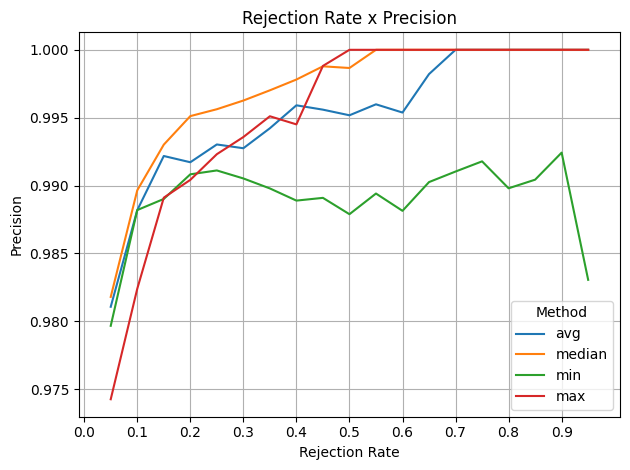

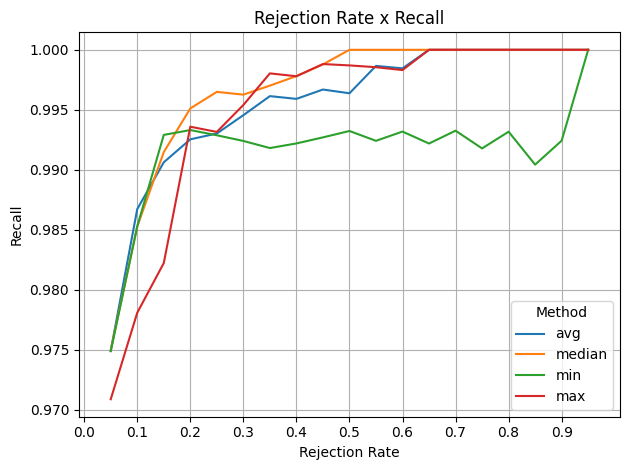

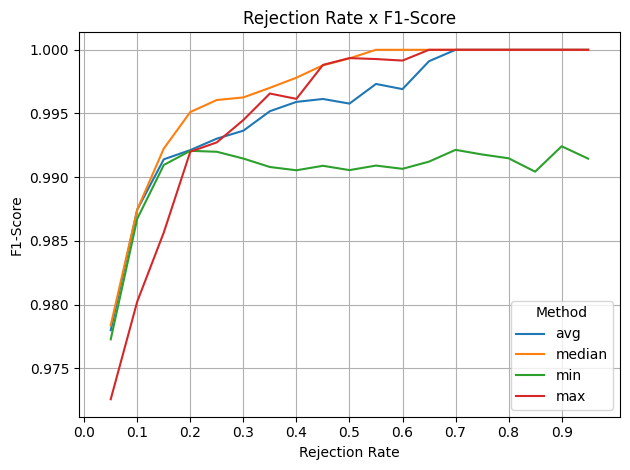

In [147]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [161]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.896
Method: median 	 |  Score: 0.897
Method: min 	 |  Score: 0.892
Method: max 	 |  Score: 0.896


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.05,0.977895,0.981066,0.974913,0.977980,0.896015
1,avg,0.10,0.987407,0.988183,0.986726,0.987454,0.896015
2,avg,0.15,0.991373,0.992175,0.990625,0.991400,0.896015
3,avg,0.20,0.992083,0.991715,0.992537,0.992126,0.896015
4,avg,0.25,0.992889,0.993025,0.993025,0.993025,0.896015
...,...,...,...,...,...,...,...
71,max,0.75,1.000000,1.000000,1.000000,1.000000,0.895955
72,max,0.80,1.000000,1.000000,1.000000,1.000000,0.895955
73,max,0.85,1.000000,1.000000,1.000000,1.000000,0.895955
74,max,0.90,1.000000,1.000000,1.000000,1.000000,0.895955


In [162]:
results_log.to_csv('results/twomoons_V0.csv')

# AIRBNB

In [8]:
experiment_name = getExpName('airbnb')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/504386116767894917', creation_time=1760128217330, experiment_id='504386116767894917', last_update_time=1760128217330, lifecycle_stage='active', name='airbnb_v0_1246495320', tags={}>

In [9]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('airbnb')

In [10]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

57307f00799a49f891c3d5879123be6c


337057925ba34619a9bb81ed2fcb7a94


cd14dd0a07ae4ed2b6a8e035da6dcdbe


6bf1f8b02dae4cfa90006313ae7e1b5b


78263e20a35d46ba93f9b0bed051a4ee


30c0c01ed88d4a67824e69945bdd0a32


489829756440401cb4b763f41c9c9c32


69bc02563ab24af08e6e40ac8dffaf90


07a98b2ace084e4f833b308deb38664c


f56a84af216040f798fd6a53c1245667


55a1b97aac0144d0822d1ff36b555fe9


6ba1b13dfb42492bb170a458c6efd127


In [11]:
modelPool = Pool(models)
modelPool = modelPool.fit(X_train, X_train_norm, y_train)

Decision_Tree fitted.
SGD fitted.
Logistic_Regression fitted.
KNN fitted.
SVM_Linear fitted.
SVM_Polynomial fitted.
SVM_RBF fitted.
MLP fitted.
Random_Forest fitted.
Gradient_Boosting fitted.
AdaBoost fitted.
XGBoost fitted.


In [31]:
pred_reject = Rejector(modelPool)
results_log = pd.DataFrame(columns=['Method','Rejection Rate','Accuracy','Precision','Recall','F1-Score'])

for method in ['avg','median','min','max']:
    #score = {'avg':[],'median':[],'min':[],'max':[]}
    for reject_rate in range(5,96,5):
        y_pred = pred_reject.predictWithReject(X_test.values, X_test_norm, reject_rate, method)
        idx = y_pred.dropna().index
        acc = accuracy_score(y_test.to_numpy()[idx], y_pred[idx])
        pre = precision_score(y_test.to_numpy()[idx], y_pred[idx], zero_division=0)
        rec = recall_score(y_test.to_numpy()[idx], y_pred[idx], zero_division=0)
        f1s = f1_score(y_test.to_numpy()[idx], y_pred[idx], zero_division=0)
        results_log.loc[results_log.shape[0]] = [method,reject_rate*0.01,acc,pre,rec,f1s]

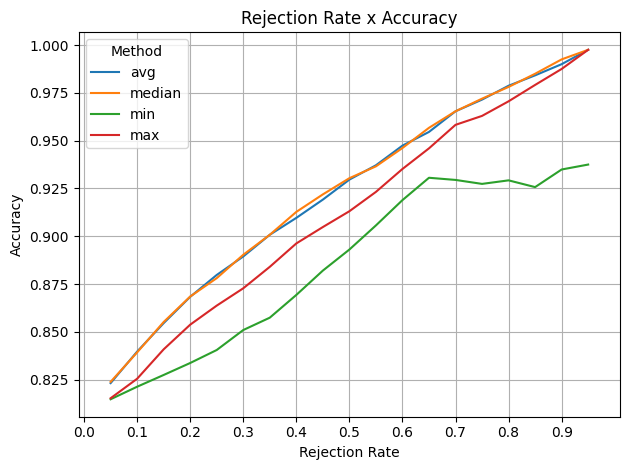

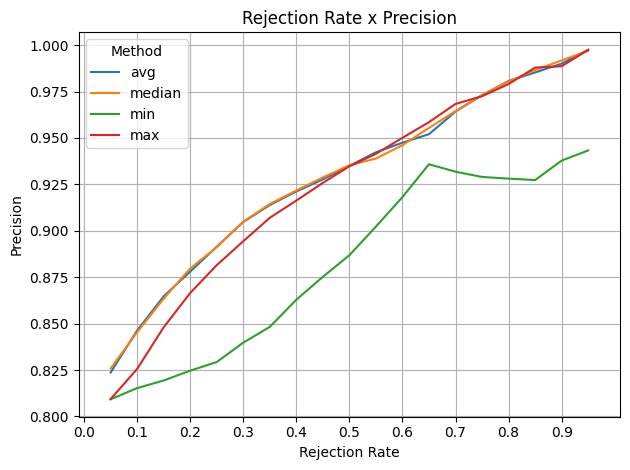

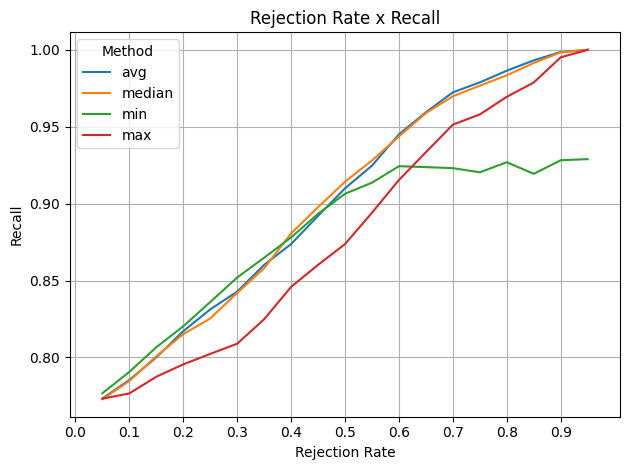

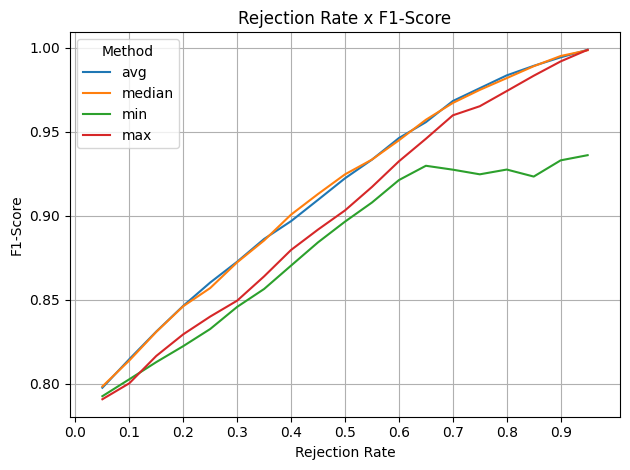

In [32]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [33]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.832
Method: median 	 |  Score: 0.832
Method: min 	 |  Score: 0.798
Method: max 	 |  Score: 0.821


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.05,0.823227,0.823676,0.773326,0.797707,0.831509
1,avg,0.10,0.839711,0.846308,0.785426,0.814731,0.831509
2,avg,0.15,0.854596,0.864721,0.800066,0.831138,0.831509
3,avg,0.20,0.868347,0.878030,0.817060,0.846449,0.831509
4,avg,0.25,0.879780,0.891435,0.831271,0.860303,0.831509
...,...,...,...,...,...,...,...
71,max,0.75,0.962944,0.972512,0.957983,0.965193,0.821208
72,max,0.80,0.970570,0.979052,0.969432,0.974218,0.821208
73,max,0.85,0.979132,0.987936,0.978752,0.983322,0.821208
74,max,0.90,0.987484,0.988636,0.995098,0.991857,0.821208


In [34]:
results_log.to_csv('results/airbnb_V0.csv')